#Modelo BLIP-2

In [ ]:
# ============================================================
# PROYECTO LAB - BLIP-2 Flan-T5-XL
# Modelo 2: BLIP-2 para Image Captioning y OCR
# ============================================================


# Instalar todas las dependencias necesarias
!pip install -q transformers accelerate pillow
!pip install -q jiwer  # Para métricas OCR (CER, WER)
!pip install -q nltk evaluate bert-score

import os
import json
import time
import psutil
import torch
import gc
from PIL import Image
from google.colab import drive
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import matplotlib.pyplot as plt

# Librerías para métricas
import jiwer
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from evaluate import load

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.0 MB/s eta 0:00:00


In [ ]:
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)


True

In [ ]:
# ============================================================
# CELDA 2: Montar Google Drive
# ============================================================
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# ============================================================
# CELDA 3: Configuración de rutas
# ============================================================
OCR_path = '/content/drive/MyDrive/Imágenes Proyecto/OCR'
IC_path = '/content/drive/MyDrive/Imágenes Proyecto/IC'
output_path = '/content/drive/MyDrive/Imágenes Proyecto/'
annotations_path = '/content/drive/MyDrive/Imágenes Proyecto/annotations.json'  # Aquí irán tus ground truths

print("✓ Rutas configuradas")

print("✓ Rutas configuradas")


✓ Rutas configuradas
✓ Rutas configuradas


In [ ]:
# ============================================================
# CELDA 4: Función para cargar imágenes
# ============================================================
def load_images_from_folder(folder):
    """
    Carga imágenes de una carpeta y devuelve lista de diccionarios.
    """
    images = []
    if not os.path.exists(folder):
        print(f"⚠️  Advertencia: La carpeta {folder} no existe")
        return images

    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(folder, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                images.append({
                    "filename": filename,
                    "path": img_path,
                    "image": img
                })
            except Exception as e:
                print(f"⚠️  Error cargando {filename}: {e}")

    return images

def show_sample(image, title=""):
    """Muestra una imagen de muestra"""
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

print("✓ Funciones de carga definidas")

✓ Funciones de carga definidas


In [ ]:
def load_annotations(annotations_file):
    """
    Carga las anotaciones manuales (ground truth).
    Formato esperado:
    {
      "imagen1.jpg": {
        "ic": {
          "basic": "descripción básica",
          "intermediate": "descripción intermedia",
          "advanced": "descripción avanzada"
        },
        "ocr": ["versión 1 del texto", "versión 2 del texto"]
      }
    }
    """
    if os.path.exists(annotations_file):
        with open(annotations_file, 'r', encoding='utf-8') as f:
            return json.load(f)
    else:
        print(f"⚠️ Archivo de anotaciones no encontrado: {annotations_file}")
        return {}

print("✓ Funciones auxiliares definidas")

✓ Funciones auxiliares definidas


In [ ]:
def calculate_cer(reference, hypothesis):
    """Calcula Character Error Rate"""
    return jiwer.cer(reference, hypothesis)

def calculate_wer(reference, hypothesis):
    """Calcula Word Error Rate"""
    return jiwer.wer(reference, hypothesis)

def calculate_bleu(reference, hypothesis):
    """
    Calcula BLEU score
    reference: string o lista de strings
    hypothesis: string
    """
    # Tokenizar
    ref_tokens = [reference.lower().split()] if isinstance(reference, str) else [ref.lower().split() for ref in reference]
    hyp_tokens = hypothesis.lower().split()

    # Usar smoothing para evitar 0s en n-gramas cortos
    smooth = SmoothingFunction().method1
    score = sentence_bleu(ref_tokens, hyp_tokens, smoothing_function=smooth)
    return score

def calculate_meteor(reference, hypothesis):
    """Calcula METEOR score usando la librería evaluate"""
    meteor = load('meteor')
    score = meteor.compute(predictions=[hypothesis], references=[reference])
    return score['meteor']

def calculate_bertscore(reference, hypothesis):
    """Calcula BERTScore F1"""
    bertscore = load('bertscore')
    results = bertscore.compute(predictions=[hypothesis], references=[reference], lang='en')
    return results['f1'][0]  # Retorna F1 score

print("✓ Funciones de métricas definidas")

✓ Funciones de métricas definidas


In [ ]:
model_id = "Salesforce/blip2-opt-2.7b"
local_model_path = "/content/drive/MyDrive/modelos/blip2-opt-2.7b"

# Verificar si el modelo está guardado en Drive
if os.path.exists(local_model_path) and os.path.exists(os.path.join(local_model_path, "config.json")):
    print("✓ Modelo encontrado en Drive!")
    print(f"Cargando desde: {local_model_path}")
    print(" Esto tomará ~30-60 segundos...")

    processor = Blip2Processor.from_pretrained(local_model_path)
    print("✓ Processor cargado desde Drive")

    model = Blip2ForConditionalGeneration.from_pretrained(
        local_model_path,
        torch_dtype=torch.float16,
        device_map="auto"
    )
    print("✓ Modelo cargado desde Drive")

else:
    print("Modelo NO encontrado en Drive")
    print("Descargando desde HuggingFace...")
    print(" Primera descarga: 2-3 minutos")

    processor = Blip2Processor.from_pretrained(model_id)
    print("✓ Processor descargado")

    model = Blip2ForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        device_map="auto"
    )
    print("✓ Modelo descargado")

    # Guardar en Drive para próximas ejecuciones
    print(f"\n Guardando modelo en Drive para futuras ejecuciones...")
    print(f"Ruta: {local_model_path}")
    os.makedirs(local_model_path, exist_ok=True)

    processor.save_pretrained(local_model_path)
    print("✓ Processor guardado")

    model.save_pretrained(local_model_path)
    print("✓ Modelo guardado")
    print("✓ En próximas ejecuciones cargará en ~30 segundos")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n✓ Dispositivo: {device}")
print(f"✓ Memoria GPU usada: {torch.cuda.memory_allocated()/1024**3:.2f} GB")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Modelo NO encontrado en Drive
Descargando desde HuggingFace...
 Primera descarga: 2-3 minutos


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


✓ Processor descargado


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

✓ Modelo descargado

 Guardando modelo en Drive para futuras ejecuciones...
Ruta: /content/drive/MyDrive/modelos/blip2-opt-2.7b
✓ Processor guardado
✓ Modelo guardado
✓ En próximas ejecuciones cargará en ~30 segundos

✓ Dispositivo: cuda
✓ Memoria GPU usada: 7.17 GB


In [ ]:
def generate_blip2_text(img, prompt="", model=None, processor=None, max_new_tokens=150):
    """
    Genera texto con BLIP-2 y mide tiempo y memoria.

    NOTA IMPORTANTE sobre BLIP-2:
    - BLIP-2 OPT funciona mejor con prompts CORTOS o sin prompt
    - Para IC: usa prompts simples o déjalo en blanco
    - Para OCR: BLIP-2 no está optimizado para OCR, los resultados serán limitados
    """
    if not isinstance(img, Image.Image):
        img = Image.fromarray(img).convert("RGB")

    # Limpiar cache
    torch.cuda.empty_cache()

    # Medir memoria y tiempo
    mem_before = torch.cuda.memory_allocated() / (1024**2)
    start_time = time.time()

    # Preparar inputs
    if prompt and len(prompt.strip()) > 0:
        # Con prompt (para tareas específicas)
        inputs = processor(images=img, text=prompt, return_tensors="pt").to(device, torch.float16)
    else:
        # Sin prompt (para descripción libre - mejor para BLIP-2)
        inputs = processor(images=img, return_tensors="pt").to(device, torch.float16)

    # Generar
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=5,
            length_penalty=1.0,
            early_stopping=True
        )

    # Decodificar
    text = processor.decode(generated_ids[0], skip_special_tokens=True)

    # Si usamos prompt, a veces se repite en la salida
    if prompt and text.startswith(prompt):
        text = text[len(prompt):].strip()

    # Métricas de ejecución
    end_time = time.time()
    mem_after = torch.cuda.memory_allocated() / (1024**2)
    inference_time = end_time - start_time
    memory_used = mem_after - mem_before

    return text, inference_time, memory_used

print("✓ Función de generación definida")

✓ Función de generación definida


✓ Se cargaron 15 imágenes OCR
✓ Se cargaron 15 imágenes IC
✓ Anotaciones cargadas: 30 imágenes


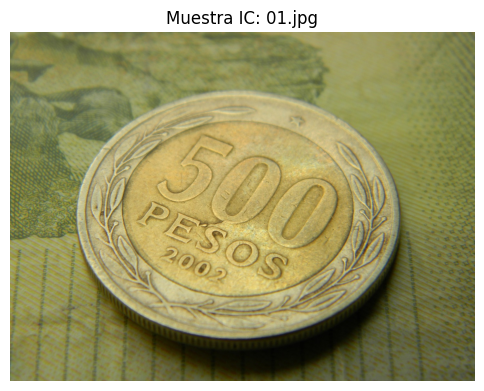

In [ ]:
# ============================================================
# CELDA 7: Cargar imágenes
# ============================================================
OCR_imgs = load_images_from_folder(OCR_path)
IC_imgs = load_images_from_folder(IC_path)
annotations = load_annotations(annotations_path)


print(f"✓ Se cargaron {len(OCR_imgs)} imágenes OCR")
print(f"✓ Se cargaron {len(IC_imgs)} imágenes IC")
print(f"✓ Anotaciones cargadas: {len(annotations)} imágenes")


# Mostrar una muestra
if len(IC_imgs) > 0:
    show_sample(IC_imgs[0]["image"], f"Muestra IC: {IC_imgs[0]['filename']}")


In [ ]:
# Verificar que el modelo esté en GPU
print("Dispositivo del modelo:", model.device)
print("GPU disponible:", torch.cuda.is_available())
print("Memoria GPU usada:", torch.cuda.memory_allocated()/1024**3, "GB")

# Ver si hay imágenes cargadas
print("Imágenes IC:", len(IC_imgs))
if len(IC_imgs) > 0:
    print("Primera imagen:", IC_imgs[0]["filename"])
    print("Tamaño imagen:", IC_imgs[0]["image"].size)

Dispositivo del modelo: cuda:0
GPU disponible: True
Memoria GPU usada: 7.182602405548096 GB
Imágenes IC: 15
Primera imagen: 01.jpg
Tamaño imagen: (1440, 1080)


In [ ]:
print("Verificando carga de imágenes...")
print(f"IC_imgs existe: {('IC_imgs' in dir())}")
print(f"Cantidad IC: {len(IC_imgs) if 'IC_imgs' in dir() else 'No definido'}")
print(f"OCR_imgs existe: {('OCR_imgs' in dir())}")
print(f"Cantidad OCR: {len(OCR_imgs) if 'OCR_imgs' in dir() else 'No definido'}")

if len(IC_imgs) > 0:
    print("\nPrimeras 3 imágenes IC:")
    for i, img in enumerate(IC_imgs[:3]):
        print(f"  {i+1}. {img['filename']}")
else:
    print("\n IC_imgs está vacío!")
    print(f"Ruta IC: {IC_path}")
    print(f"¿Existe la ruta? {os.path.exists(IC_path)}")
    if os.path.exists(IC_path):
        print(f"Archivos en la carpeta: {os.listdir(IC_path)}")

Verificando carga de imágenes...
IC_imgs existe: True
Cantidad IC: 15
OCR_imgs existe: True
Cantidad OCR: 15

Primeras 3 imágenes IC:
  1. 01.jpg
  2. 02.jpg
  3. 03.jpg


In [ ]:

# ============================================================
# CELDA 8: Test rápido
# ============================================================
if len(IC_imgs) > 0:
    print("\n=== TEST RÁPIDO ===")
    test_img = IC_imgs[0]["image"]

    # Test sin prompt (mejor para BLIP-2)
    caption, exec_time, mem_used = generate_blip2_text(
        test_img, "", model, processor
    )
    print(f"Sin prompt: {caption}")
    print(f"Tiempo: {exec_time:.2f}s | Memoria: {mem_used:.2f}MB")

    # Test con prompt simple
    caption2, exec_time2, mem_used2 = generate_blip2_text(
        test_img, "a photo of", model, processor
    )
    print(f"\nCon prompt 'a photo of': {caption2}")
    print(f"Tiempo: {exec_time2:.2f}s | Memoria: {mem_used2:.2f}MB")



=== TEST RÁPIDO ===
Sin prompt: a 500 peso coin sitting on top of a bank note

Tiempo: 0.58s | Memoria: 0.29MB

Con prompt 'a photo of': a 500 peso coin sitting on top of a bill
Tiempo: 0.45s | Memoria: 0.30MB


In [ ]:
ic_prompts = {
    "basic": "",  # Sin prompt = descripción natural básica
    "intermediate": "a photo of",  # Prompt mínimo
    "advanced": "a detailed image of"  # Prompt simple para más detalle
}
print("✓ Prompts definidos (optimizados para BLIP-2)")


✓ Prompts definidos (optimizados para BLIP-2)


In [ ]:
# ============================================================
# CELDA 10: Procesar todas las imágenes IC
# ============================================================
ic_results = []
ic_times = []
ic_memory = []

print("\n" + "="*60)
print("PROCESANDO IMAGE CAPTIONING")
print("="*60)

for idx, img_info in enumerate(IC_imgs):
    filename = img_info["filename"]
    img = img_info["image"]

    print(f"\n[{idx+1}/{len(IC_imgs)}] Procesando: {filename}")

    # Obtener anotaciones de esta imagen
    img_annotations = annotations.get(filename, {}).get("ic", {})

    img_prompts = []

    for level, prompt in ic_prompts.items():
        # Generar caption
        caption, exec_time, mem_used = generate_blip2_text(
            img, prompt, model, processor, max_new_tokens=150
        )

        ic_times.append(exec_time)
        ic_memory.append(mem_used)

        print(f"  - {level}: {exec_time:.2f}s")
        print(f"    Output: {caption[:80]}...")

        # Calcular métricas si hay ground truth
        reference = img_annotations.get(level, "")
        score_a = None
        score_b = None

        if reference:
            try:
                # Usaremos BLEU y METEOR para IC
                score_a = calculate_bleu(reference, caption)
                score_b = calculate_meteor(reference, caption)
                print(f"    BLEU: {score_a:.4f} | METEOR: {score_b:.4f}")
            except Exception as e:
                print(f"  Error calculando métricas: {e}")

        img_prompts.append({
            "prompt": prompt if prompt else "[no prompt - free description]",
            "output": caption,
            "scores": {
                "score_a": score_a,  # BLEU
                "score_b": score_b   # METEOR
            }
        })

    ic_results.append({
        "image_path": img_info["path"],
        "model": "BLIP2-OPT-2.7B",
        "task": "IC",
        "annotations": list(img_annotations.values()) if img_annotations else [],
        "prompt_outputs": img_prompts
    })

print(f"\n✓ IC completado: {len(ic_results)} imágenes procesadas")
if ic_times:
    print(f"✓ Tiempo promedio: {sum(ic_times)/len(ic_times):.2f}s por imagen")
    print(f"✓ Memoria promedio: {sum(ic_memory)/len(ic_memory):.2f}MB por inferencia")



PROCESANDO IMAGE CAPTIONING

[1/15] Procesando: 01.jpg
  - basic: 0.57s
    Output: a 500 peso coin sitting on top of a bank note
...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


    BLEU: 0.1109 | METEOR: 0.5556
  - intermediate: 0.50s
    Output: a 500 peso coin sitting on top of a bill...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0718 | METEOR: 0.3175
  - advanced: 0.39s
    Output: a 500 peso coin...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0562

[2/15] Procesando: 02.jpg
  - basic: 0.39s
    Output: a train track in the middle of nowhere
...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0278 | METEOR: 0.1408
  - intermediate: 0.39s
    Output: a train track in the middle of nowhere...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0038 | METEOR: 0.0413
  - advanced: 0.39s
    Output: a train track in the desert...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0372

[3/15] Procesando: 03.jpg
  - basic: 0.55s
    Output: a close up of a woman's hand with a ring on it
...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0241 | METEOR: 0.1786
  - intermediate: 0.47s
    Output: a woman's hand with a ring on it...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0078 | METEOR: 0.1425
  - advanced: 0.39s
    Output: a woman's hand with a ring on it...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0309

[4/15] Procesando: 04.jpg
  - basic: 0.48s
    Output: the sun is setting over the ocean
...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0992 | METEOR: 0.1739
  - intermediate: 0.30s
    Output: the sun setting over the ocean...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0009 | METEOR: 0.0442
  - advanced: 0.30s
    Output: the sun setting over the ocean...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0204

[5/15] Procesando: 05.jpg
  - basic: 0.42s
    Output: a field of yellow flowers under a cloudy sky
...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.3303 | METEOR: 0.7052
  - intermediate: 0.39s
    Output: a field of yellow flowers...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0014 | METEOR: 0.1522
  - advanced: 0.30s
    Output: a field of yellow flowers...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0332

[6/15] Procesando: 06.jpg
  - basic: 0.31s
    Output: a man riding a skateboard
...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0463 | METEOR: 0.1442
  - intermediate: 0.33s
    Output: a man on a skateboard...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0010 | METEOR: 0.0364
  - advanced: 0.33s
    Output: a man on a skateboard...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0172

[7/15] Procesando: 07.jpg
  - basic: 0.42s
    Output: the bus is upside down
...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0000
  - intermediate: 0.31s
    Output: a bus that is upside down...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0003 | METEOR: 0.0280
  - advanced: 0.43s
    Output: a bus that is upside down...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0132

[8/15] Procesando: 08.jpg
  - basic: 0.32s
    Output: the stairs are made of wood
...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0000
  - intermediate: 0.30s
    Output: a staircase in a house...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0002 | METEOR: 0.0156
  - advanced: 0.30s
    Output: a staircase in a room...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0223

[9/15] Procesando: 09.jpg
  - basic: 0.30s
    Output: the building is made of stone
...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0346 | METEOR: 0.1282
  - intermediate: 0.27s
    Output: a building...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0158
  - advanced: 0.31s
    Output: a building...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0108

[10/15] Procesando: 10.jpg
  - basic: 0.37s
    Output: a statue of a man and a dog
...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0968 | METEOR: 0.3182
  - intermediate: 0.27s
    Output: a statue...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0257
  - advanced: 0.27s
    Output: a statue...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0111

[11/15] Procesando: 11.jpg
  - basic: 0.37s
    Output: a tall building with a lot of windows
...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0650 | METEOR: 0.2247
  - intermediate: 0.37s
    Output: a tall building with a lot of windows...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0013 | METEOR: 0.0836
  - advanced: 0.34s
    Output: a tall building with people on it...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0429

[12/15] Procesando: 12.jpg
  - basic: 0.27s
    Output: yellow building with arches
...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0625 | METEOR: 0.2206
  - intermediate: 0.28s
    Output: a building...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0149
  - advanced: 0.22s
    Output: a building...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0073

[13/15] Procesando: 13.jpg
  - basic: 0.42s
    Output: a fruit stand with boxes of oranges and lemons
...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0240 | METEOR: 0.1111
  - intermediate: 0.33s
    Output: a fruit market...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0413
  - advanced: 0.39s
    Output: a fruit market...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0171

[14/15] Procesando: 14.jpg
  - basic: 0.45s
    Output: a merry go round at night
...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0524 | METEOR: 0.2662
  - intermediate: 0.31s
    Output: a carousel at night...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0002 | METEOR: 0.0514
  - advanced: 0.31s
    Output: a carousel at night...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0000 | METEOR: 0.0259

[15/15] Procesando: 15.jpg
  - basic: 0.48s
    Output: a man dressed as santa claus riding on a motorcycle
...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.3247 | METEOR: 0.8212
  - intermediate: 0.40s
    Output: santa claus riding on a motorcycle...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


    BLEU: 0.0020 | METEOR: 0.1803
  - advanced: 0.37s
    Output: santa claus riding a motorcycle...
    BLEU: 0.0000 | METEOR: 0.0513

✓ IC completado: 15 imágenes procesadas
✓ Tiempo promedio: 0.36s por imagen
✓ Memoria promedio: 0.30MB por inferencia


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# ============================================================
# CELDA 11: Definir prompts para OCR
# ============================================================
# ocr_prompts = {
#     "ocr_extract": "Extract and transcribe all the text visible in this image exactly as it appears.",
#     "ocr_read": "Read all the text in this image line by line in reading order."
# }

# print("✓ Prompts OCR definidos")

ocr_prompts = {
    "ocr_extract": "text:",  # Prompt mínimo
    "ocr_read": "the text says"  # Alternativa
}

# ocr_prompts = {
#     "ocr_extract": "Extract all text from this image:",
#     "ocr_read": "What text is visible in this image?"
# }

print("✓ Prompts definidos (optimizados para BLIP-2)")



✓ Prompts definidos (optimizados para BLIP-2)


In [ ]:
ocr_results = []
ocr_times = []
ocr_memory = []

print("\n" + "="*60)
print("PROCESANDO OCR")
print("="*60)
print("NOTA: BLIP-2 NO está optimizado para OCR. Resultados limitados esperados.")

for idx, img_info in enumerate(OCR_imgs):
    filename = img_info["filename"]
    img = img_info["image"]

    print(f"\n[{idx+1}/{len(OCR_imgs)}] Procesando: {filename}")

    # Obtener anotaciones de esta imagen
    img_annotations = annotations.get(filename, {}).get("ocr", [])

    img_prompts = []

    for mode, prompt in ocr_prompts.items():
        # Intentar extraer texto
        text, exec_time, mem_used = generate_blip2_text(
            img, prompt, model, processor, max_new_tokens=200
        )

        ocr_times.append(exec_time)
        ocr_memory.append(mem_used)

        print(f"  - {mode}: {exec_time:.2f}s")
        print(f"    Output: {text[:80]}...")

        # Calcular métricas si hay ground truth
        reference = img_annotations[0] if img_annotations else ""
        score_a = None
        score_b = None

        if reference:
            try:
                score_a = calculate_cer(reference, text)
                score_b = calculate_wer(reference, text)
                print(f"    CER: {score_a:.4f} | WER: {score_b:.4f}")
            except Exception as e:
                print(f"    Error calculando métricas: {e}")

        img_prompts.append({
            "prompt": prompt,
            "output": text,
            "scores": {
                "score_a": score_a,  # CER
                "score_b": score_b   # WER
            }
        })

    ocr_results.append({
        "image_path": img_info["path"],
        "model": "BLIP2-OPT-2.7B",
        "task": "OCR",
        "annotations": img_annotations,
        "prompt_outputs": img_prompts
    })

print(f"\n✓ OCR completado: {len(ocr_results)} imágenes procesadas")
if ocr_times:
    print(f"✓ Tiempo promedio: {sum(ocr_times)/len(ocr_times):.2f}s por imagen")
    print(f"✓ Memoria promedio: {sum(ocr_memory)/len(ocr_memory):.2f}MB por inferencia")




PROCESANDO OCR
NOTA: BLIP-2 NO está optimizado para OCR. Resultados limitados esperados.

[1/15] Procesando: 20220101_035959.jpg
  - ocr_extract: 0.72s
    Output: para ordenar el sistema se prohíbe el uso de drogas...
    CER: 0.9000 | WER: 1.0000
  - ocr_read: 0.62s
    Output: "para ordenar el sistema se prohíbe"...
    CER: 0.9444 | WER: 1.0000

[2/15] Procesando: 20230214_122422.jpg
  - ocr_extract: 0.60s
    Output: el museo nacional de ciencias sociales...
    CER: 0.6750 | WER: 1.0000
  - ocr_read: 0.44s
    Output: el museo nacional nacional...
    CER: 0.5750 | WER: 1.0000

[3/15] Procesando: 20230430_150424.jpg
  - ocr_extract: 0.30s
    Output: "smilodon"...
    CER: 0.9091 | WER: 1.0000
  - ocr_read: 0.36s
    Output: "smilodon"...
    CER: 0.9091 | WER: 1.0000

[4/15] Procesando: 20230511_133754.jpg
  - ocr_extract: 1.11s
    Output: the hotel is located in the center of the city, in the heart of the historic cen...
    CER: 5.9091 | WER: 9.6667
  - ocr_read: 0.46s
    O

In [ ]:

# 12. GUARDAR RESULTADOS

# %%
# Combinar resultados
all_results = ic_results + ocr_results

# Guardar results.json
output_file = os.path.join(output_path, "results_blip2.json")
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(all_results, f, ensure_ascii=False, indent=2)

# Crear estadísticas
stats = {
    "model": "BLIP2-OPT-2.7B",
    "model_size_GB": 5.5,  # Aproximado en disco
    "model_parameters": "2.7B",
    "device": device,
    "ic_stats": {
        "num_images": len(IC_imgs),
        "avg_time_per_image": sum(ic_times)/len(ic_times) if ic_times else 0,
        "avg_memory_MB": sum(ic_memory)/len(ic_memory) if ic_memory else 0,
        "total_time": sum(ic_times)
    },
    "ocr_stats": {
        "num_images": len(OCR_imgs),
        "avg_time_per_image": sum(ocr_times)/len(ocr_times) if ocr_times else 0,
        "avg_memory_MB": sum(ocr_memory)/len(ocr_memory) if ocr_memory else 0,
        "total_time": sum(ocr_times)
    },
    "notes": "BLIP-2 OPT 2.7B is optimized for image captioning, not OCR. OCR performance will be limited."
}

stats_file = os.path.join(output_path, "blip2_statistics.json")
with open(stats_file, "w", encoding="utf-8") as f:
    json.dump(stats, f, indent=2)

print(f"\n✓ Resultados guardados en: {output_file}")
print(f"✓ Estadísticas guardadas en: {stats_file}")



✓ Resultados guardados en: /content/drive/MyDrive/Imágenes Proyecto/results_blip2.json
✓ Estadísticas guardadas en: /content/drive/MyDrive/Imágenes Proyecto/blip2_statistics.json


In [ ]:
print("\n" + "="*70)
print("RESUMEN DE EJECUCIÓN - BLIP-2 OPT 2.7B")
print("="*70)
print(f"Modelo: BLIP2-OPT-2.7B (2.7 mil millones de parámetros)")
print(f"Dispositivo: {device}")
print(f"Tamaño aproximado: 5.5 GB en disco")
print(f"\nImage Captioning:")
print(f"  - Imágenes procesadas: {len(IC_imgs)}")
print(f"  - Tiempo promedio: {stats['ic_stats']['avg_time_per_image']:.2f}s")
print(f"  - Memoria promedio: {stats['ic_stats']['avg_memory_MB']:.2f}MB")
print(f"  - Métricas usadas: BLEU (score_a), METEOR (score_b)")
print(f"\nOCR:")
print(f"  - Imágenes procesadas: {len(OCR_imgs)}")
print(f"  - Tiempo promedio: {stats['ocr_stats']['avg_time_per_image']:.2f}s")
print(f"  - Memoria promedio: {stats['ocr_stats']['avg_memory_MB']:.2f}MB")
print(f"  - Métricas usadas: CER (score_a), WER (score_b)")
print(f"\n NOTA IMPORTANTE:")
print(f"BLIP-2 está optimizado para Image Captioning, NO para OCR.")
print(f"Para OCR se recomienda usar modelos especializados como:")
print(f"  - TrOCR, PaddleOCR, EasyOCR, Tesseract")
print(f"\nArchivos generados:")
print(f"  - {output_file}")
print(f"  - {stats_file}")
print("="*70)


RESUMEN DE EJECUCIÓN - BLIP-2 OPT 2.7B
Modelo: BLIP2-OPT-2.7B (2.7 mil millones de parámetros)
Dispositivo: cuda
Tamaño aproximado: 5.5 GB en disco

Image Captioning:
  - Imágenes procesadas: 15
  - Tiempo promedio: 0.36s
  - Memoria promedio: 0.30MB
  - Métricas usadas: BLEU (score_a), METEOR (score_b)

OCR:
  - Imágenes procesadas: 15
  - Tiempo promedio: 0.55s
  - Memoria promedio: 0.30MB
  - Métricas usadas: CER (score_a), WER (score_b)

 NOTA IMPORTANTE:
BLIP-2 está optimizado para Image Captioning, NO para OCR.
Para OCR se recomienda usar modelos especializados como:
  - TrOCR, PaddleOCR, EasyOCR, Tesseract

Archivos generados:
  - /content/drive/MyDrive/Imágenes Proyecto/results_blip2.json
  - /content/drive/MyDrive/Imágenes Proyecto/blip2_statistics.json


In [ ]:

# ============================================================
# CELDA 15: Ver ejemplos de resultados
# ============================================================
print("\n=== EJEMPLOS DE RESULTADOS ===")

if ic_results:
    print("\n--- Ejemplo IC ---")
    ejemplo = ic_results[0]
    print(f"Imagen: {os.path.basename(ejemplo['image_path'])}")
    for output in ejemplo['prompt_outputs']:
        print(f"\nPrompt: {output['prompt']}")
        print(f"Output: {output['output']}")
        if output['scores']['score_a']:
            print(f"BLEU: {output['scores']['score_a']:.4f} | METEOR: {output['scores']['score_b']:.4f}")

if ocr_results:
    print("\n--- Ejemplo OCR ---")
    ejemplo = ocr_results[0]
    print(f"Imagen: {os.path.basename(ejemplo['image_path'])}")
    for output in ejemplo['prompt_outputs']:
        print(f"\nPrompt: {output['prompt']}")
        print(f"Output: {output['output']}")
        if output['scores']['score_a']:
            print(f"CER: {output['scores']['score_a']:.4f} | WER: {output['scores']['score_b']:.4f}")



=== EJEMPLOS DE RESULTADOS ===

--- Ejemplo IC ---
Imagen: 01.jpg

Prompt: [no prompt - free description]
Output: a 500 peso coin sitting on top of a bank note

BLEU: 0.1109 | METEOR: 0.5556

Prompt: a photo of
Output: a 500 peso coin sitting on top of a bill
BLEU: 0.0718 | METEOR: 0.3175

Prompt: a detailed image of
Output: a 500 peso coin
BLEU: 0.0000 | METEOR: 0.0562

--- Ejemplo OCR ---
Imagen: 20220101_035959.jpg

Prompt: text:
Output: para ordenar el sistema se prohíbe el uso de drogas
CER: 0.9000 | WER: 1.0000

Prompt: the text says
Output: "para ordenar el sistema se prohíbe"
CER: 0.9444 | WER: 1.0000


In [ ]:
# Ejecuta esto y cópiame el output:
with open('/content/drive/MyDrive/Imágenes Proyecto/results_blip2.json', 'r', encoding='utf-8') as f:
    results = json.load(f)

# Mostrar estructura de las primeras 2 imágenes
print(json.dumps(results[:2], indent=2, ensure_ascii=False))

[
  {
    "image_path": "/content/drive/MyDrive/Imágenes Proyecto/IC/01.jpg",
    "model": "BLIP2-OPT-2.7B",
    "task": "IC",
    "annotations": [
      "A Chilean 500 peso coin on a banknote.",
      "A gold-colored 500 peso coin from 2002 sits on top of a Chilean banknote. The coin displays its denomination clearly with decorative laurel branches around the edge.",
      "A circular bi-metallic Chilean coin showing 500 PESOS denomination dated 2002 rests on a greenish banknote with visible security features and patterns. The coin features prominent numbers with ornamental laurel wreaths encircling the text, showing signs of circulation wear. The underlying currency displays intricate printing details, with the image captured from directly above under natural lighting conditions."
    ],
    "prompt_outputs": [
      {
        "prompt": "[no prompt - free description]",
        "output": "a 500 peso coin sitting on top of a bank note\n",
        "scores": {
          "score_a": 0.110

In [ ]:

print("\n=== RESULTADOS DETALLADOS ===")

# IC - Primera imagen con TODAS las variaciones de prompt
if ic_results:
    ejemplo_ic = ic_results[0]
    print("\n--- IMAGE CAPTIONING ---")
    print(f"Imagen: {os.path.basename(ejemplo_ic['image_path'])}")
    for i, output in enumerate(ejemplo_ic['prompt_outputs']):
        print(f"\n  Prompt {i+1}: '{output['prompt']}'")
        print(f"  Output: {output['output']}")
        print(f"  Scores: {output['scores']}")

# OCR - Primera imagen con AMBOS prompts
if ocr_results:
    ejemplo_ocr = ocr_results[0]
    print("\n--- OCR ---")
    print(f"Imagen: {os.path.basename(ejemplo_ocr['image_path'])}")
    for i, output in enumerate(ejemplo_ocr['prompt_outputs']):
        print(f"\n  Prompt {i+1}: '{output['prompt']}'")
        print(f"  Output: {output['output']}")
        print(f"  Scores: {output['scores']}")


=== RESULTADOS DETALLADOS ===

--- IMAGE CAPTIONING ---
Imagen: 01.jpg

  Prompt 1: '[no prompt - free description]'
  Output: a 500 peso coin sitting on top of a bank note

  Scores: {'score_a': 0.11094660471566163, 'score_b': np.float64(0.5555555555555555)}

  Prompt 2: 'a photo of'
  Output: a 500 peso coin sitting on top of a bill
  Scores: {'score_a': 0.07176076472605042, 'score_b': np.float64(0.317525397476197)}

  Prompt 3: 'a detailed image of'
  Output: a 500 peso coin
  Scores: {'score_a': 1.8613396041775065e-07, 'score_b': np.float64(0.05616103202846975)}

--- OCR ---
Imagen: 20220101_035959.jpg

  Prompt 1: 'text:'
  Output: para ordenar el sistema se prohíbe el uso de drogas
  Scores: {'score_a': 0.9, 'score_b': 1.0}

  Prompt 2: 'the text says'
  Output: "para ordenar el sistema se prohíbe"
  Scores: {'score_a': 0.9444444444444444, 'score_b': 1.0}


In [ ]:
#statics
with open('/content/drive/MyDrive/Imágenes Proyecto/blip2_statistics.json', 'r', encoding='utf-8') as f:
    stats = json.load(f)
print(json.dumps(stats, indent=2))

{
  "model": "BLIP2-OPT-2.7B",
  "model_size_GB": 5.5,
  "model_parameters": "2.7B",
  "device": "cuda",
  "ic_stats": {
    "num_images": 15,
    "avg_time_per_image": 0.3643730004628499,
    "avg_memory_MB": 0.2950846354166667,
    "total_time": 16.396785020828247
  },
  "ocr_stats": {
    "num_images": 15,
    "avg_time_per_image": 0.5548550287882487,
    "avg_memory_MB": 0.29736328125,
    "total_time": 16.64565086364746
  },
  "notes": "BLIP-2 OPT 2.7B is optimized for image captioning, not OCR. OCR performance will be limited."
}


In [ ]:
# ============================================================
# CELDA 16: Limpiar memoria
# ============================================================
# Ejecuta esto al final para liberar recursos
torch.cuda.empty_cache()
gc.collect()
print("\n✓ Memoria GPU liberada")


✓ Memoria GPU liberada
